In [ ]:
%load_ext autoreload
%autoreload 2
from spyglass.decoding.v1.waveform_features import (
    UnitWaveformFeatures,
    WaveformFeaturesParams,
)
from spyglass.decoding.v1.clusterless import UnitWaveformFeaturesGroup


from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
import numpy as np
import matplotlib.pyplot as plt

import os

cur_dir = os.path.realpath(os.curdir)
cur_dir
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")
from Analysis.utils import filter_opto_data
from ms_opto_stim_protocol import OptoStimProtocol

import numpy as np
import scipy.signal


def smooth(data, n=5, sigma=None, hamming=False, mode='valid'):
    """smooths data with gaussian kernel of size n"""
    if n % 2 == 0:
        n += 1  # make sure n is odd
    if sigma is None:
        sigma = n / 2
    kernel = gkern(n, sigma)[:, None]
    if hamming:
        n = sigma
        kernel = np.ones((sigma, 1)) / sigma
    if len(data.shape) == 1:
        pad = np.ones(((n - 1) // 2, 1))
        return np.squeeze(
            scipy.signal.convolve2d(
                np.concatenate(
                    [pad * data[:, None][0], data[:, None], pad * data[:, None][-1]],
                    axis=0,
                ),
                kernel,
                mode=mode,
            )
        )
    else:
        pad = np.ones(((n - 1) // 2, data.shape[1]))
        return scipy.signal.convolve2d(
            np.concatenate([pad * data[0], data, pad * data[-1]], axis=0),
            kernel,
            mode=mode,
        )


def gkern(l: int = 5, sig: float = 1.0):
    """
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    return gauss / np.sum(gauss)
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

os.chdir(cur_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [597]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeatures

times_list, marks_list = (
    UnitWaveformFeatures()
    & {"features_param_name": "amplitude_probe"}
    & "analysis_file_name LIKE 'wilbur20210404%'"
).fetch_data()

[2025-03-20 10:37:35,708][WARNING]: Skipped checksum for file with hash: e3a99702-abe1-398d-a7ac-4f90aa189e32, and path: /stelmo/nwb/analysis/wilbur20210404/wilbur20210404_7M6KBR92WS.nwb
[2025-03-20 10:37:59,959][WARNING]: Skipped checksum for file with hash: e3a99702-abe1-398d-a7ac-4f90aa189e32, and path: /stelmo/nwb/analysis/wilbur20210404/wilbur20210404_7M6KBR92WS.nwb
[2025-03-20 10:37:59,964][WARNING]: Skipped checksum for file with hash: e3a99702-abe1-398d-a7ac-4f90aa189e32, and path: /stelmo/nwb/analysis/wilbur20210404/wilbur20210404_7M6KBR92WS.nwb


In [4]:
subsample = 1
mark_times = []
marks = []

n_shanks = len(times_list)

for shank, (t, m) in enumerate(zip(times_list, marks_list)):
    mark_times.extend(t)
    # mark = np.zeros((len(t),m.shape[1],n_shanks))
    # mark[:, :, shank] = m
    # marks.extend(mark)
    mark = np.zeros((len(t), 32 + 1))
    mark[:, : m.shape[1]] = m
    mark[:, -1] = shank
    marks.extend(mark)
    # break


marks = np.array(marks)
mark_times = np.array(mark_times)
print(marks.shape, mark_times.shape)

ind = np.argsort(mark_times)
mark_times = mark_times[ind]
marks = marks[ind]

# standardize marks
marks[:, :-1] = marks[:, :-1] - np.mean(marks[:, :-1], axis=1)[:, None]
#     :, None, :
# ]
# standardize times
first_mark_time = mark_times[0]
mark_times = mark_times - first_mark_time
# mark_times[mark_times > 10] = 10
mark_times = mark_times * 1000
# print(np.max(np.abs(marks)))
marks[:, :-1] = marks[:, :-1] / 1000  # np.max(np.abs(marks))

marks = marks[::subsample]
mark_times = mark_times[::subsample]

(36937458, 33) (36937458,)


# Load Trial Info

In [5]:
import os

os.chdir("/home/xulu/code/alison_spyglass")
# from alison_subject import SpatialBanditSubjects
from alison_behav import *
from alison_rlmodel import BehaviorModelResults

# from alison_position import PosValidTimesToEpoch

subject = "wilbur"
date = "20210404"
file_name = subject + date
nwb_file_name = file_name + "_.nwb"
behavior_model_params_name = "default_hmm"
trials_info_by_rat_params_name = "decay_default"  # For some animals or sessions it could be 'decay_default2' where Alison reran the HMM
behav_results = BehaviorModelResults.ByDay() & {
    "nwb_file_name": nwb_file_name,
    "behavior_model_params_name": behavior_model_params_name,
    "trials_info_by_rat_params_name": trials_info_by_rat_params_name,
}
all_behav = behav_results.fetch1_dataframe()
all_behav

behav_results
script_table = StateScriptTrials() & {"nwb_file_name": nwb_file_name}
trials = []
epoch = []
t_poke = []
t_out = []
for epoch_i in script_table.fetch("epoch"):
    table = script_table & {"epoch": epoch_i}
    trials.extend(table.fetch1("trial"))
    epoch.extend([epoch_i] * len(table.fetch1("trial")))
    t_poke.extend(table.fetch1("poke_in_ts"))
    t_out.extend(table.fetch1("poke_out_ts"))
script_df = pd.DataFrame(
    {"epoch": epoch, "trial_number_by_epoch": trials, "t_poke": t_poke, "t_out": t_out},
)
script_df

##
trial_df = pd.merge(all_behav, script_df, on=["epoch", "trial_number_by_epoch"])
turn_lookup = {
    (1, 2): "right",
    (2, 1): "left",
    (3, 4): "right",
    (4, 3): "left",
    (5, 6): "right",
    (6, 5): "left",
}

fill_entries = [
    (1, "left", [3, 4, 5, 6]),
    (2, "right", [3, 4, 5, 6]),
    (3, "left", [1, 2, 5, 6]),
    (4, "right", [1, 2, 5, 6]),
    (5, "left", [1, 2, 3, 4]),
    (6, "right", [1, 2, 3, 4]),
]
for fill_entry in fill_entries:
    port, turn, other_ports = fill_entry
    for other_port in other_ports:
        turn_lookup[(port, other_port)] = turn

turns = []
for epoch in trial_df["epoch"].unique():
    epoch_df = trial_df[trial_df["epoch"] == epoch]
    turns.append("start")
    for i in range(1, len(epoch_df)):
        turn = turn_lookup[(epoch_df["leaf"].values[i - 1], epoch_df["leaf"].values[i])]
        turns.append(turn)
if "turns" not in trial_df.columns:
    trial_df["turns"] = turns


trial_df

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/name

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,contingency,date,session,rewscaled,...,stem_turn_alone_var,leaf_1_var,leaf_2_var,stem_choice_p,leaf_choice_p,stem_choice_var,leaf_choice_var,t_poke,t_out,turns
0,wilbur20210404_.nwb,2,0,3,B,1,202050802050,20210404,1,1,...,6.039716e-31,6.317667e-04,6.317667e-04,0.333333,0.500000,0.133689,6.317667e-04,1.617554e+09,1.617554e+09,start
1,wilbur20210404_.nwb,2,1,4,B,1,202040802050,20210404,1,1,...,7.888609e-31,7.888609e-31,7.888609e-31,0.989541,0.000000,0.115108,7.888609e-31,1.617554e+09,1.617554e+09,right
2,wilbur20210404_.nwb,2,2,5,C,0,202050802050,20210404,1,-1,...,1.428324e-01,5.592752e-04,5.592752e-04,0.000212,0.500000,0.037972,5.592752e-04,1.617554e+09,1.617554e+09,right
3,wilbur20210404_.nwb,2,3,6,C,0,202050801650,20210404,1,-1,...,4.930381e-32,4.930381e-32,4.930381e-32,0.648113,0.000000,0.154470,4.930381e-32,1.617554e+09,1.617554e+09,right
4,wilbur20210404_.nwb,2,4,5,C,0,202050801640,20210404,1,-1,...,7.888609e-31,7.888609e-31,7.888609e-31,0.414533,0.000000,0.149147,7.888609e-31,1.617554e+09,1.617554e+09,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,wilbur20210404_.nwb,10,295,4,B,0,205040128050,20210404,5,-1,...,4.437343e-31,4.437343e-31,4.437343e-31,0.833310,0.000000,0.145471,4.437343e-31,1.617573e+09,1.617573e+09,right
1496,wilbur20210404_.nwb,10,296,5,C,0,205080208050,20210404,5,-1,...,1.561186e-01,6.635374e-04,6.635374e-04,0.080430,0.499998,0.085461,6.635374e-04,1.617573e+09,1.617573e+09,right
1497,wilbur20210404_.nwb,10,297,6,C,1,205080206450,20210404,5,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.981971,0.000000,0.134209,0.000000e+00,1.617573e+09,1.617573e+09,right
1498,wilbur20210404_.nwb,10,298,5,C,1,205080206440,20210404,5,1,...,1.774937e-30,1.774937e-30,1.774937e-30,0.953495,0.000000,0.120429,1.774937e-30,1.617573e+09,1.617573e+09,left


In [529]:
from spyglass.common import Nwbfile
from pynwb import NWBHDF5IO
from spyglass.utils.nwb_helper_fn import get_nwb_file
from spyglass.utils.dj_helper_fn import _get_nwb_object
from spyglass.common import DIOEvents, Nwbfile, interval_list_intersect
import numpy as np

file_path = Nwbfile().get_abs_path("wilbur20210404_.nwb")
nwb = get_nwb_file(file_path)
dio_query = (
    DIOEvents()
    & {"nwb_file_name": "wilbur20210404_.nwb"}
    & "dio_event_name LIKE 'pump%'"
)

pump_obj_ids = dio_query.fetch("dio_object_id")
all_pump_intervals = []
for obj_id in pump_obj_ids:
    obj = _get_nwb_object(nwb.objects, obj_id)
    state = obj.data[:]
    state_time = obj.timestamps[:]
    ind_on = np.where(state == 1)[0]
    pump_intervals = [
        [st, en] for st, en in zip(state_time[ind_on], state_time[ind_on + 1])
    ]
    all_pump_intervals.extend(pump_intervals)
all_pump_intervals = np.array(all_pump_intervals)
ind = np.argsort(all_pump_intervals[:, 0])
all_pump_intervals = all_pump_intervals[ind]

dio_query = (
    DIOEvents()
    & {"nwb_file_name": "wilbur20210404_.nwb"}
    & "dio_event_name LIKE 'poke%'"
)
poke_obj_ids = dio_query.fetch("dio_object_id")
all_poke_intervals = []
for obj_id in poke_obj_ids:
    obj = _get_nwb_object(nwb.objects, obj_id)
    state = obj.data[:]
    state_time = obj.timestamps[:]
    ind_on = np.where(state == 1)[0]
    poke_intervals = [
        [st, en] for st, en in zip(state_time[ind_on], state_time[ind_on + 1])
    ]
    all_poke_intervals.extend(poke_intervals)
all_poke_intervals = np.array(all_poke_intervals)
ind = np.argsort(all_poke_intervals[:, 0])
all_poke_intervals = all_poke_intervals[ind]

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/name

# Train

## Prep data format

In [6]:
# prep data for model
delta_t = np.diff(mark_times)[None, ...]
# delta_t[delta_t >10] = 10
x = marks[1:][None, ...]


ind = np.where(delta_t[0] > 0)[0]
x = x[:, ind]
marks = marks[ind]
mark_times = mark_times[ind]
delta_t = delta_t[:, ind]  # *1000

In [8]:
import jax
import numpy as np

filter_position = True


subsample = 1
sample_length = 7000  # 7000
i = sample_length
x_train = []
delta_t_train = []

n_trials = 1000
for t_start, t_end in zip(t_out[:n_trials], t_poke[1 : n_trials + 1]):
    # loc = np.digitize(
    #     t_end - first_mark_time,
    #     mark_times / 1000,
    # )
    # x_train.append(x[0, loc - sample_length : loc])
    # delta_t_train.append(delta_t[0, loc - sample_length : loc])
    loc_start = np.digitize(
        t_start - first_mark_time,
        mark_times / 1000,
    )
    loc_end = np.digitize(
        t_end - first_mark_time,
        mark_times / 1000,
    )
    # print(loc_end-loc_start)
    # print(np.sum(delta_t[0][loc_start:loc_end]))
    trial_length = np.sum(delta_t[0][loc_start:loc_end])
    if trial_length / 1000 > 20:
        continue  # skip trials that are too long

    i = loc_start + int(sample_length * 0.2)
    while i < loc_end + sample_length // 2:
        if subsample == 1:
            x_train.append(marks[i - sample_length : i])
            delta_t_train.append(delta_t[0, i - sample_length : i])
        else:
            for j in range(subsample):
                x_train.append(marks[i - sample_length + j : i + j : subsample])
                # delta_t_train.append(delta_t[0, i - sample_length + j : i + j : subsample])
                truncated_arr = delta_t[0, i - sample_length + j : i + j]
                reshaped = truncated_arr.reshape(sample_length // subsample, subsample)
                delta_t_train.append(np.sum(reshaped, axis=-1))

        i += int(sample_length // 4)


x_train = np.array(x_train)
delta_t_train = np.array(delta_t_train)

print(x_train.shape, delta_t_train.shape)
print(np.mean(np.sum(delta_t_train, axis=1)))

(5408, 7000, 33) (5408, 7000)
3508.358468758989


## Make the model

In [10]:
from flax.linen import initializers
import os

initializers.lecun_normal()
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7,8,9"  # "5,6,7,8"
import jax

os.listdir()
# os.chdir('..')
os.chdir("/home/sambray/Documents/c3po/")
from src.c3po.model.model import C3PO

os.listdir()
os.chdir("/home/sambray/Documents/c3po/")

In [11]:
# prep data for model
from src.c3po.model.util import prep_training_data
from src.c3po.model.model import C3PO

keep_params = 0  # True

if keep_params:
    store_params = params.copy()
# hyperparams
latent_dim = 32  # 4
context_dim = 10  # 6
encoder_widths = [64, 32, 32]
# context_widths = [12, 12, 12]


n_neg_samples = 32
shank_args = dict(encoder_model="simple", widths=encoder_widths)
# shank_args = dict(
#     encoder_model="convolutional1D",
#     conv_kernel_sizes=[8, 4, 4],
#     conv_strides=[2, 2, 2],
#     conv_features=[16, 16, 16],
#     widths=[16, 8, 8],
# )
encoder_args = dict(
    shank_encoder_params=shank_args,
    encoder_model="multi_shank_v1",
    n_shanks=marks.shape[-1],
)

# )
# V1
dilations = [1, 2, 4, 16, 32, 64, 128, 256]
dilations = dilations * 3
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,
    layer_kernel_size=np.ones(len(dilations)).astype(int) * 3,
    expanded_dim=128,
    smoothing=20,
)

# V2
dilations = [1, 2, 3, 4, 4]
dilations = dilations * 2
kernels = [32, 32, 64, 128, 256]
kernels = kernels * 2
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=10,
    categorical=False,
)

rate_args = dict(
    rate_model="bilinearLinear",
)

distribution = "poisson"  # "multi_loglogistic"  # "gompertz"
predicted_sequence_length = 5


model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution,
    latent_dim,
    context_dim,
    n_neg_samples,
    predicted_sequence_length,
)


rand_key = jax.random.PRNGKey(0)
params = model.init(jax.random.PRNGKey(1), x[:, :300], delta_t[:, :300], rand_key)
init_params = params.copy()
run_model = jax.jit(model.apply)
if keep_params:
    params = store_params.copy()
x_train.shape

x shape (1, 33)


Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


(1, 5, 295, 32)
(1, 300, 32) (1, 5, 295, 1)
neg_z (1, 32, 300, 32)
c (1, 300, 10)
neg_params (1, 32, 295, 1)


(5408, 7000, 33)

# Run Optimization

In [ ]:
params = jax.device_put_replicated(init_params, jax.devices())
prior_params = {
    "mu": -np.mean(np.log(delta_t_train)),
    "sigma": np.std(np.log10(delta_t_train)),
}
prior_params

from jax import pmap


def stalled_training(loss_history):
    val = loss_history[-3:]
    if np.std(val) / np.mean(val) < 1e-2:
        return True
    return False


def change_n_neg_samples(params, x, delta_t, rand_key, n_neg_samples):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
    )
    run_model = jax.jit(model.apply)

    @pmap
    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params = run_model(params, x, delta_t, rand_key)
        return model.loss_generalized_model(
            pos_params,
            neg_params,
            delta_t,
            scale_neg_samples=2 * predicted_sequence_length,
            sample_step=2,
            rand_key=rand_key,
        )

    @pmap
    def compute_gradients(params, x, delta_t, rand_key):
        def training_loss_fun(params, x, delta_t, rand_key):
            pos_params, neg_params = run_model(params, x, delta_t, rand_key)
            return model.loss_generalized_model(
                pos_params,
                neg_params,
                delta_t,
                scale_neg_samples=2 * predicted_sequence_length,
                sample_step=2,
                rand_key=rand_key,
                prior_params=prior_params,
            )

        loss, grads = value_and_grad(training_loss_fun)(params, x, delta_t, rand_key)
        return loss, grads

    def run_batches(params, opt_state, x, delta_t, rand_key):
        x_batch, delta_t_batch = get_batches(
            x,
            delta_t,
        )
        losses, grads = compute_gradients(
            params, x_batch, delta_t_batch, jax.random.split(rand_key, num_devices)
        )
        rand_key = jax.random.split(rand_key)[0]

        # Optional: Apply updates separately per GPU
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, np.mean(losses)

    return run_batches

Epoch 1/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 32, 7000, 32)
c (64, 7000, 10)
neg_params (64, 32, 6995, 1)
Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>


Epoch 1/3000:  50%|████▉     | 2688/5408 [00:54<00:54, 49.66samples/s, batch_size=64, loss=137, n_neg=32] 
/tmp/ipykernel_592909/261717729.py:26: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  single_device_params = jax.tree_map(lambda x: x[0], params)


x shape (10, 33)


Epoch 5/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 64, 7000, 32)
c (64, 7000, 10)
neg_params (64, 64, 6995, 1)


Epoch 13/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 128, 7000, 32)
c (64, 7000, 10)
neg_params (64, 128, 6995, 1)


Epoch 16/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 256, 7000, 32)
c (64, 7000, 10)
neg_params (64, 256, 6995, 1)


Epoch 20/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 512, 7000, 32)
c (64, 7000, 10)
neg_params (64, 512, 6995, 1)


Epoch 23/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 1024, 7000, 32)
c (64, 7000, 10)
neg_params (64, 1024, 6995, 1)


Epoch 27/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 2048, 7000, 32)
c (64, 7000, 10)
neg_params (64, 2048, 6995, 1)


Epoch 30/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (64, 33)
(64, 5, 6995, 32)
(64, 7000, 32) (64, 5, 6995, 1)
neg_z (64, 4096, 7000, 32)
c (64, 7000, 10)
neg_params (64, 4096, 6995, 1)


Epoch 33/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (32, 33)
(32, 5, 6995, 32)
(32, 7000, 32) (32, 5, 6995, 1)
neg_z (32, 128, 7000, 32)
c (32, 7000, 10)
neg_params (32, 128, 6995, 1)


Epoch 38/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (32, 33)
(32, 5, 6995, 32)
(32, 7000, 32) (32, 5, 6995, 1)
neg_z (32, 256, 7000, 32)
c (32, 7000, 10)
neg_params (32, 256, 6995, 1)


Epoch 41/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (32, 33)
(32, 5, 6995, 32)
(32, 7000, 32) (32, 5, 6995, 1)
neg_z (32, 512, 7000, 32)
c (32, 7000, 10)
neg_params (32, 512, 6995, 1)


Epoch 44/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (32, 33)
(32, 5, 6995, 32)
(32, 7000, 32) (32, 5, 6995, 1)
neg_z (32, 1024, 7000, 32)
c (32, 7000, 10)
neg_params (32, 1024, 6995, 1)


Epoch 47/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (32, 33)
(32, 5, 6995, 32)
(32, 7000, 32) (32, 5, 6995, 1)
neg_z (32, 2048, 7000, 32)
c (32, 7000, 10)
neg_params (32, 2048, 6995, 1)


Epoch 50/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (32, 33)
(32, 5, 6995, 32)
(32, 7000, 32) (32, 5, 6995, 1)
neg_z (32, 4096, 7000, 32)
c (32, 7000, 10)
neg_params (32, 4096, 6995, 1)


Epoch 53/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (16, 33)
(16, 5, 6995, 32)
(16, 7000, 32) (16, 5, 6995, 1)
neg_z (16, 128, 7000, 32)
c (16, 7000, 10)
neg_params (16, 128, 6995, 1)


Epoch 57/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (16, 33)
(16, 5, 6995, 32)
(16, 7000, 32) (16, 5, 6995, 1)
neg_z (16, 256, 7000, 32)
c (16, 7000, 10)
neg_params (16, 256, 6995, 1)


Epoch 60/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (16, 33)
(16, 5, 6995, 32)
(16, 7000, 32) (16, 5, 6995, 1)
neg_z (16, 512, 7000, 32)
c (16, 7000, 10)
neg_params (16, 512, 6995, 1)


Epoch 63/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (16, 33)
(16, 5, 6995, 32)
(16, 7000, 32) (16, 5, 6995, 1)
neg_z (16, 1024, 7000, 32)
c (16, 7000, 10)
neg_params (16, 1024, 6995, 1)


Epoch 66/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (16, 33)
(16, 5, 6995, 32)
(16, 7000, 32) (16, 5, 6995, 1)
neg_z (16, 2048, 7000, 32)
c (16, 7000, 10)
neg_params (16, 2048, 6995, 1)


Epoch 69/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (16, 33)
(16, 5, 6995, 32)
(16, 7000, 32) (16, 5, 6995, 1)
neg_z (16, 4096, 7000, 32)
c (16, 7000, 10)
neg_params (16, 4096, 6995, 1)


Epoch 72/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (8, 33)
(8, 5, 6995, 32)
(8, 7000, 32) (8, 5, 6995, 1)
neg_z (8, 128, 7000, 32)
c (8, 7000, 10)
neg_params (8, 128, 6995, 1)


Epoch 76/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (8, 33)
(8, 5, 6995, 32)
(8, 7000, 32) (8, 5, 6995, 1)
neg_z (8, 256, 7000, 32)
c (8, 7000, 10)
neg_params (8, 256, 6995, 1)


Epoch 79/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (8, 33)
(8, 5, 6995, 32)
(8, 7000, 32) (8, 5, 6995, 1)
neg_z (8, 512, 7000, 32)
c (8, 7000, 10)
neg_params (8, 512, 6995, 1)


Epoch 82/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (8, 33)
(8, 5, 6995, 32)
(8, 7000, 32) (8, 5, 6995, 1)
neg_z (8, 1024, 7000, 32)
c (8, 7000, 10)
neg_params (8, 1024, 6995, 1)


Epoch 85/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (8, 33)
(8, 5, 6995, 32)
(8, 7000, 32) (8, 5, 6995, 1)
neg_z (8, 2048, 7000, 32)
c (8, 7000, 10)
neg_params (8, 2048, 6995, 1)


Epoch 88/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (8, 33)
(8, 5, 6995, 32)
(8, 7000, 32) (8, 5, 6995, 1)
neg_z (8, 4096, 7000, 32)
c (8, 7000, 10)
neg_params (8, 4096, 6995, 1)


Epoch 91/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (4, 33)
(4, 5, 6995, 32)
(4, 7000, 32) (4, 5, 6995, 1)
neg_z (4, 128, 7000, 32)
c (4, 7000, 10)
neg_params (4, 128, 6995, 1)


Epoch 95/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (4, 33)
(4, 5, 6995, 32)
(4, 7000, 32) (4, 5, 6995, 1)
neg_z (4, 256, 7000, 32)
c (4, 7000, 10)
neg_params (4, 256, 6995, 1)


Epoch 98/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (4, 33)
(4, 5, 6995, 32)
(4, 7000, 32) (4, 5, 6995, 1)
neg_z (4, 512, 7000, 32)
c (4, 7000, 10)
neg_params (4, 512, 6995, 1)


Epoch 101/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (4, 33)
(4, 5, 6995, 32)
(4, 7000, 32) (4, 5, 6995, 1)
neg_z (4, 1024, 7000, 32)
c (4, 7000, 10)
neg_params (4, 1024, 6995, 1)


Epoch 104/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (4, 33)
(4, 5, 6995, 32)
(4, 7000, 32) (4, 5, 6995, 1)
neg_z (4, 2048, 7000, 32)
c (4, 7000, 10)
neg_params (4, 2048, 6995, 1)


Epoch 107/3000:   0%|          | 0/5408 [00:00<?, ?samples/s]

x shape (4, 33)
(4, 5, 6995, 32)
(4, 7000, 32) (4, 5, 6995, 1)
neg_z (4, 4096, 7000, 32)
c (4, 7000, 10)
neg_params (4, 4096, 6995, 1)


Epoch 338/3000:  29%|██▉       | 1584/5408 [02:21<05:42, 11.17samples/s, batch_size=4, loss=42.7, n_neg=4096]


KeyboardInterrupt: 

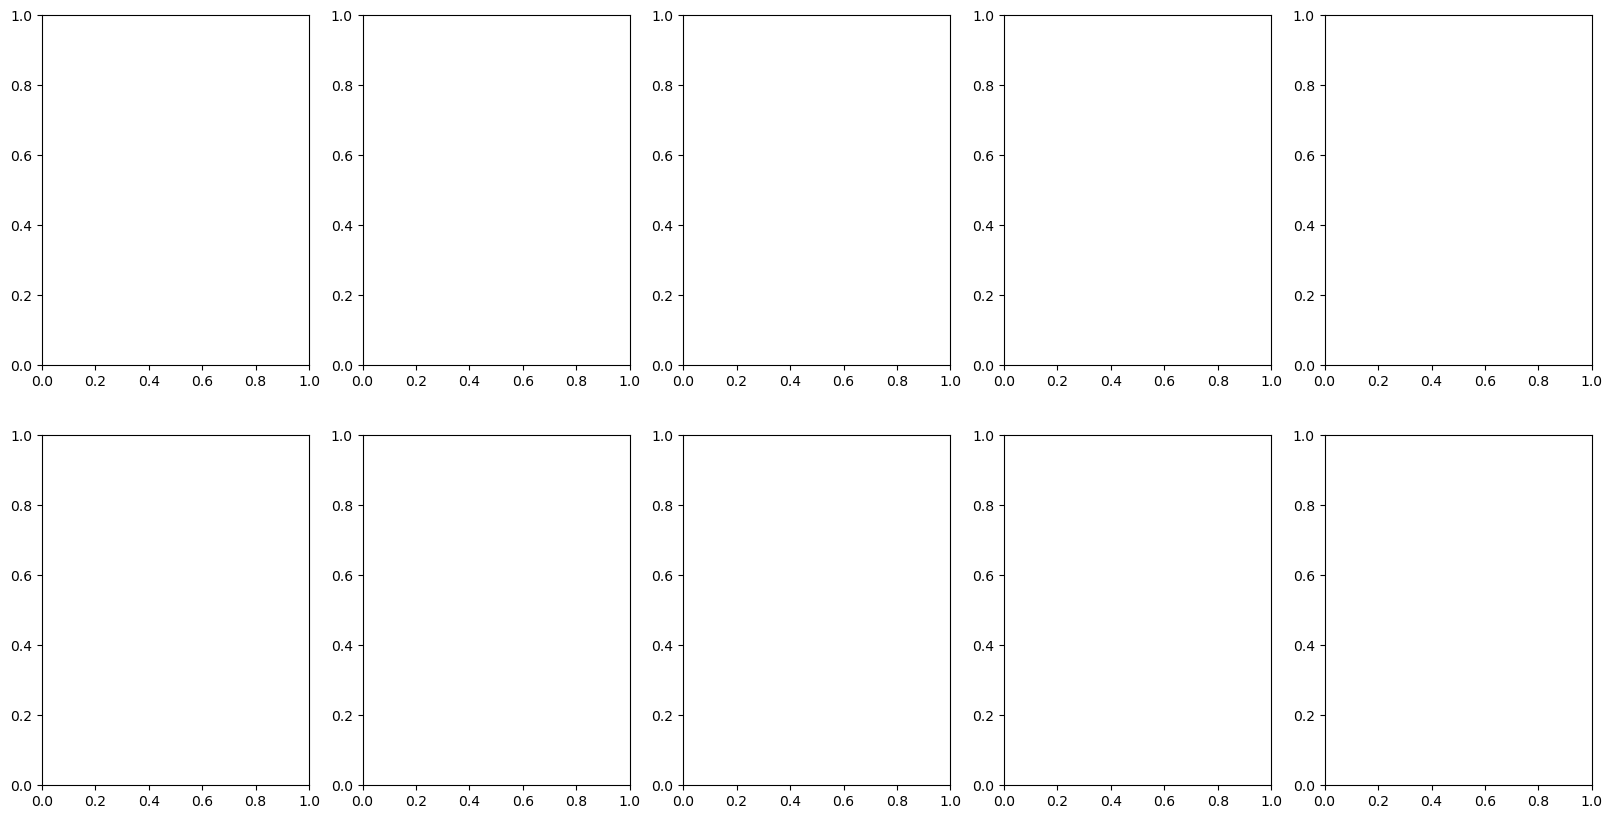

In [13]:
import jax
import jax.numpy as jnp
import optax
from jax import pmap, value_and_grad
from functools import partial

# Number of available GPUs
num_devices = jax.device_count()

# Define batch size per GPU
batch_size = 64  # Adjust as needed
total_batch_size = batch_size * num_devices
learning_rate = 1e-4
clip_sample = x_train.shape[1]
default_buffer = 3
epoch_subsample = 2

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
track_samples = np.random.choice(x_train.shape[0], 10)


@jax.jit
def embed_tracked_samples(params):
    from src.c3po.model.model import Embedding

    single_device_params = jax.tree_map(lambda x: x[0], params)
    embedding_params = {
        "params": single_device_params["params"]["embedding"],
        # "state": params["state"]["embedding"],
    }
    z, c = Embedding(encoder_args, context_args, latent_dim, context_dim).apply(
        embedding_params, x_train[track_samples], delta_t_train[track_samples]
    )
    return z, c


@pmap
def training_loss_fun(params, x, delta_t, rand_key):
    pos_params, neg_params = run_model(params, x, delta_t, rand_key)
    return model.loss_generalized_model(
        pos_params,
        neg_params,
        delta_t,
        scale_neg_samples=2 * predicted_sequence_length,
        sample_step=2,
    )


@pmap
def compute_gradients(params, x, delta_t, rand_key):
    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params = run_model(params, x, delta_t, rand_key)
        print(rand_key)
        return model.loss_generalized_model(
            pos_params,
            neg_params,
            delta_t,
            scale_neg_samples=2 * predicted_sequence_length,
            sample_step=2,
            rand_key=rand_key,
            prior_params=prior_params,
        )

    loss, grads = value_and_grad(training_loss_fun)(params, x, delta_t, rand_key)
    return loss, grads


# # Function to generate independent batches per device
def get_batches(x, delta_t):
    """Simulate getting independent batches for each device."""
    return np.array([x[i::num_devices] for i in range(num_devices)]), np.array(
        [delta_t[i::num_devices] for i in range(num_devices)]
    )


def run_batches(params, opt_state, x, delta_t, rand_key):
    x_batch, delta_t_batch = get_batches(
        x,
        delta_t,
    )
    losses, grads = compute_gradients(
        params, x_batch, delta_t_batch, jax.random.split(rand_key, num_devices)
    )
    rand_key = jax.random.split(rand_key)[0]

    # Optional: Apply updates separately per GPU
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, np.mean(losses)


# Optimizer
optimizer = optax.chain(
    # optax.clip_by_global_norm(1),
    optax.adam(learning_rate),
    # optax.clip_by_block_rms(1),
    # optax.adadelta(learning_rate),
)
# Initialize model parameters and optimizer
opt_state = optimizer.init(params)

# # Training loop
# ind = np.arange(x_train.shape[0])
# np.random.shuffle(ind)
# i=0
# while i < 1000:
#     x_batch = x_train[ind[i : i + total_batch_size]]
#     delta_t_batch = delta_t_train[ind[i : i + total_batch_size]]
#     params, opt_state, loss = run_batches(params, opt_state, x_batch, delta_t_batch, rand_key)
#     rand_key = jax.random.split(rand_key)[0]
#     i += total_batch_size

#     if step % 1 == 0:
#         print(f"Step {step}, Losses: {loss}")


######################################################################


n_neg = 32  # n_neg_samples
tracked_loss = []
tracked_n_neg = []
tracked_batch_size = []
buffer = default_buffer
from tqdm import tqdm

for i in range(30000):
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    ind = ind[: x_train.shape[0] // epoch_subsample]

    epoch_loss = []
    j = 0
    with tqdm(
        total=x_train.shape[0], desc=f"Epoch {i+1}/{3000}", unit="samples"
    ) as pbar:
        while j < ind.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + total_batch_size]
            if batch_inds.shape[0] < total_batch_size:
                break
            # loss_val, grads = loss_grad_fn(
            #     params,
            #     x_train[batch_inds, :clip_sample],
            #     delta_t_train[batch_inds, :clip_sample],
            #     rand_key,
            # )
            # updates, opt_state = optimizer.update(grads, opt_state, params)
            # params = optax.apply_updates(params, updates)
            x_batch = x_train[batch_inds, :clip_sample]
            delta_t_batch = delta_t_train[batch_inds, :clip_sample]
            params, opt_state, loss_val = run_batches(
                params, opt_state, x_batch, delta_t_batch, rand_key
            )
            rand_key = jax.random.split(rand_key)[0]
            epoch_loss.append(loss_val)

            j += total_batch_size

            pbar.update(total_batch_size)
            pbar.set_postfix(
                loss=np.mean(epoch_loss), n_neg=n_neg, batch_size=batch_size
            )

    tracked_loss.append(np.mean(epoch_loss))
    tracked_n_neg.append(n_neg)
    tracked_batch_size.append(batch_size)
    z_tracked, c_tracked = embed_tracked_samples(params)
    for t, c, a in zip(delta_t_train[track_samples], c_tracked, ax.flatten()):
        a.plot(np.cumsum(t), c)
    fig.savefig(f"sb1/{i:04}.png")
    for a in ax.flatten():
        a.clear()

    buffer -= 1

    if buffer > 0 or (not stalled_training(tracked_loss)):
        continue
    if clip_sample < sample_length:
        clip_sample += 1000
        buffer = default_buffer
        if clip_sample >= sample_length:
            clip_sample = sample_length
            # n_neg = 64
            # change_n_neg_samples(params, x_train, delta_t_train, rand_key, n_neg)
    else:
        if n_neg < 3000:
            n_neg *= 2
            # loss_grad_fn = change_n_neg_samples(
            #     params, x_train, delta_t_train, rand_key, n_neg
            # )
            run_batches = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            buffer = default_buffer
        elif batch_size > 4:
            batch_size /= 2
            batch_size = int(batch_size)
            total_batch_size = int(batch_size * num_devices)
            n_neg = 128
            run_batches = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            # loss_grad_fn = jax.value_and_grad(training_loss_fun)
            buffer = default_buffer

(-11.0, 500.0)

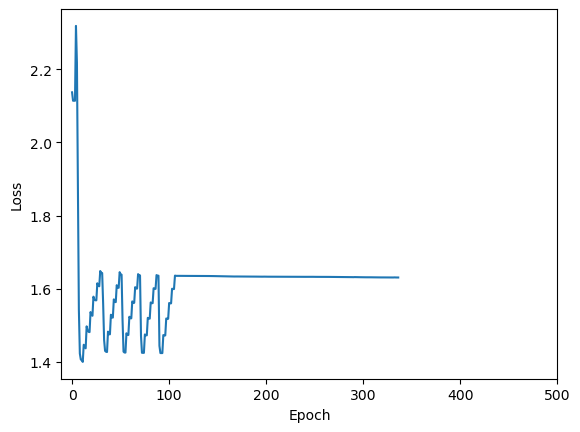

In [14]:
import matplotlib.pyplot as plt


epoch = np.arange(len(tracked_loss))
# plt.plot(epoch, tracked_loss)
plt.plot(epoch, np.log10(tracked_loss))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.xlim(-11, 500)

# Analyze: Embed the data

In [ ]:
from src.c3po.analysis.analysis import C3poAnalysis

single_device_params = jax.tree_map(lambda x: x[0], params)
model_args = dict(
    encoder_args=encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution=distribution,
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=predicted_sequence_length,
    sample_params=None,
)
analysis = C3poAnalysis(model=model, model_args=model_args, params=single_device_params)

In [22]:
x.shape, delta_t.shape

((1, 34784519, 33), (1, 34784519))

In [42]:
# analysis.embed_data(x[:], delta_t[:], first_mark_time)
# analysis.fit_context_pca()
t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.embed_context_pca()

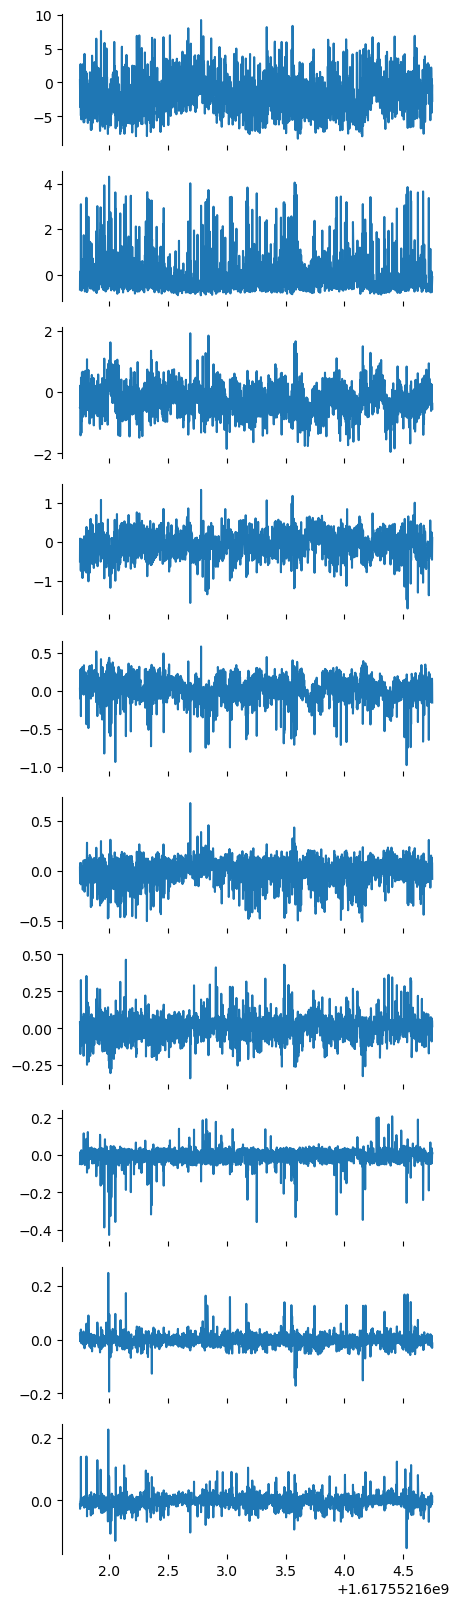

In [ ]:
ind = slice(3000, 6000)
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(5, 20))
for i, a in enumerate(ax):
    a.plot(analysis.t_interp[ind], analysis.c_pca_interp[ind, i])
    a.spines[["top", "right", "bottom"]].set_visible(False)
# plt.plot(analysis.t[ind],analysis.c_pca[ind])

# Analyze trial respoponse func

In [ ]:
all_behav.columns

Index(['nwb_file_name', 'epoch', 'trial_number_by_epoch', 'leaf', 'stem',
       'reward', 'contingency', 'date', 'session', 'rewscaled', 'stemchoice',
       'leafchoice', 'daynum', 'daysessionnum', 'stemswitch', 'n_post_switch',
       'n_pre_switch', 'cont_combo', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6',
       'Qstem1', 'Qstem2', 'Qstem3', 'Qleaf1', 'Qleaf2', 'state_entropy',
       'reward_entropy', 'reward_entropy_leaf_1', 'reward_entropy_leaf_2',
       'reward_entropy_leaf_3', 'reward_entropy_leaf_4',
       'reward_entropy_leaf_5', 'reward_entropy_leaf_6',
       'reward_entropy_current_leaf', 'reward_entropy_pair_prev_leaf',
       'reward_entropy_pair_current_leaf', 'stem_1_p', 'stem_2_p', 'stem_3_p',
       'stem_stay_p', 'stem_go_turn_p', 'stem_turn_alone_p', 'leaf_1_p',
       'leaf_2_p', 'stem_1_var', 'stem_2_var', 'stem_3_var', 'stem_stay_var',
       'stem_go_turn_var', 'stem_turn_alone_var', 'leaf_1_var', 'leaf_2_var',
       'stem_choice_p', 'leaf_choice_p', 'stem_choice_

### Categorically grouped

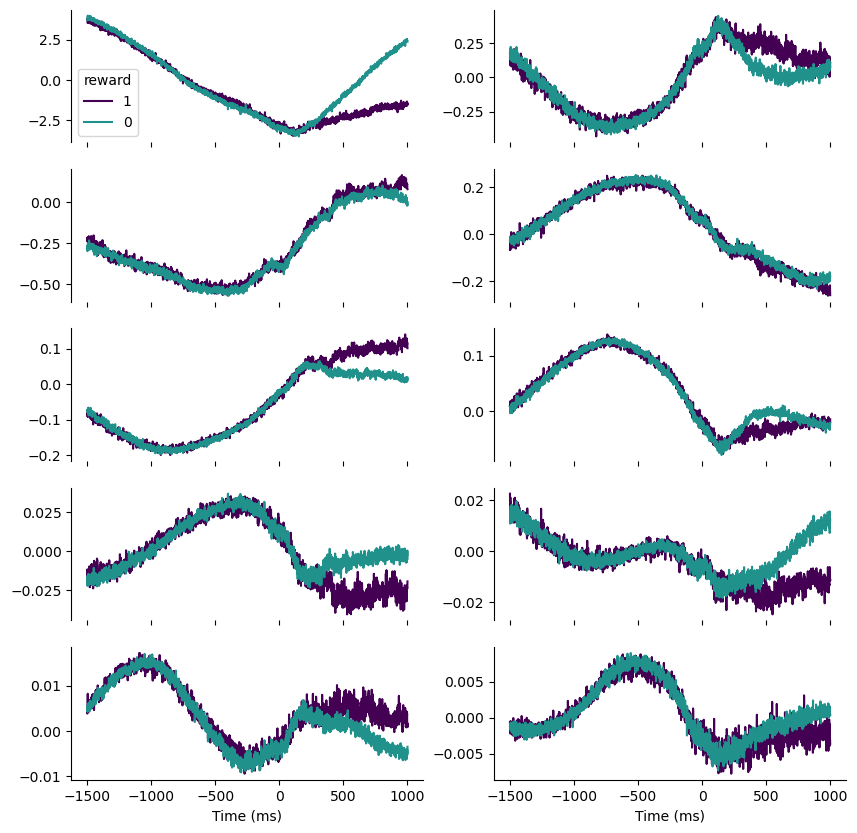

In [488]:
offset = 0
marks = t_poke
window = (-1.5, 1)
group_feature_name = "n_pre_switch"
feature_bins = None
feature_bins = np.arange(5)

group_feature_name = "reward"
feature_bins = None

plot_examples = 0
#########################################################################


marks_ind = slice(offset, None) if offset >= 0 else slice(None, offset)
feature_ind = slice(None, -offset) if offset > 0 else slice(-offset, None)
marks = marks[marks_ind]

response = analysis.alligned_response(marks, window, pca=True)
t_plot = np.linspace(*window, response.shape[1]) * 1000

# ---------------------------------------------------------------------------'
# Single feature analysis
fig, ax = plt.subplots(nrows=context_dim // 2, ncols=2, sharex=True, figsize=(10, 10))
ax = np.ravel(ax)
subset_behav = all_behav.iloc[feature_ind]

unique_vals = (
    subset_behav[group_feature_name].unique() if feature_bins is None else feature_bins
)
for i, val in enumerate(unique_vals):
    color = plt.cm.viridis(i / len(unique_vals))
    ind = subset_behav[group_feature_name] == val
    sample_ind = np.random.choice(np.where(ind)[0], plot_examples)
    for i, a in enumerate(ax):
        a.plot(t_plot, response[ind, ..., i].mean(axis=0), label=val, color=color)
        a.plot(
            t_plot, response[sample_ind, ..., i].T, alpha=0.1, zorder=-0.1, color=color
        )
        a.spines[["top", "right", "bottom"]].set_visible(False)

for a in [ax[-1], ax[-2]]:
    a.set_xlabel("Time (ms)")
    a.spines["bottom"].set_visible(True)
ax[0].legend(title=group_feature_name)
# plt.plot(t_plot, response.mean(axis=0))
# plt.xlim(-500,500)

### Categorically grouped. 2 categories

(-500.0, 500.0)

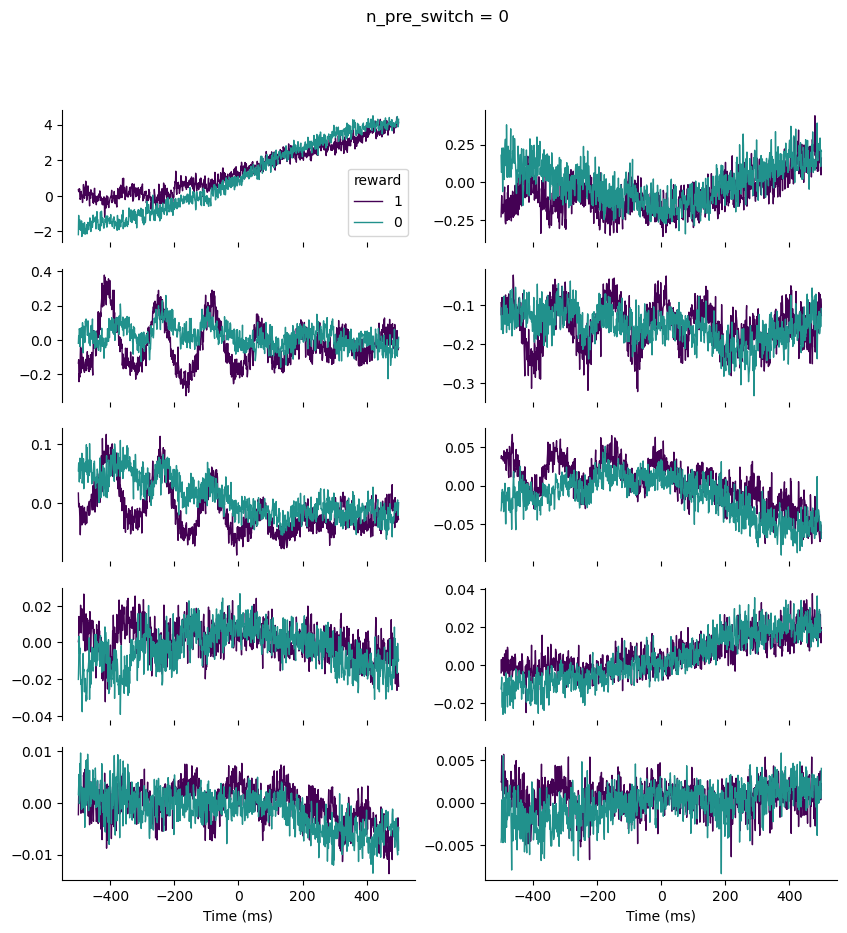

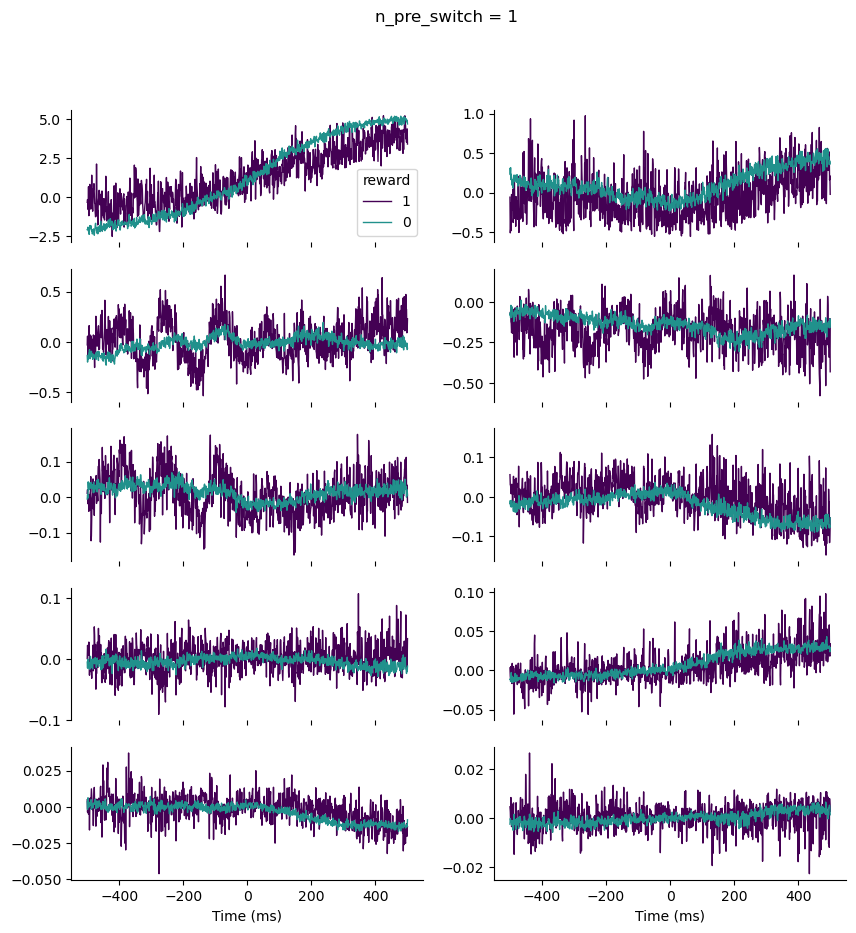

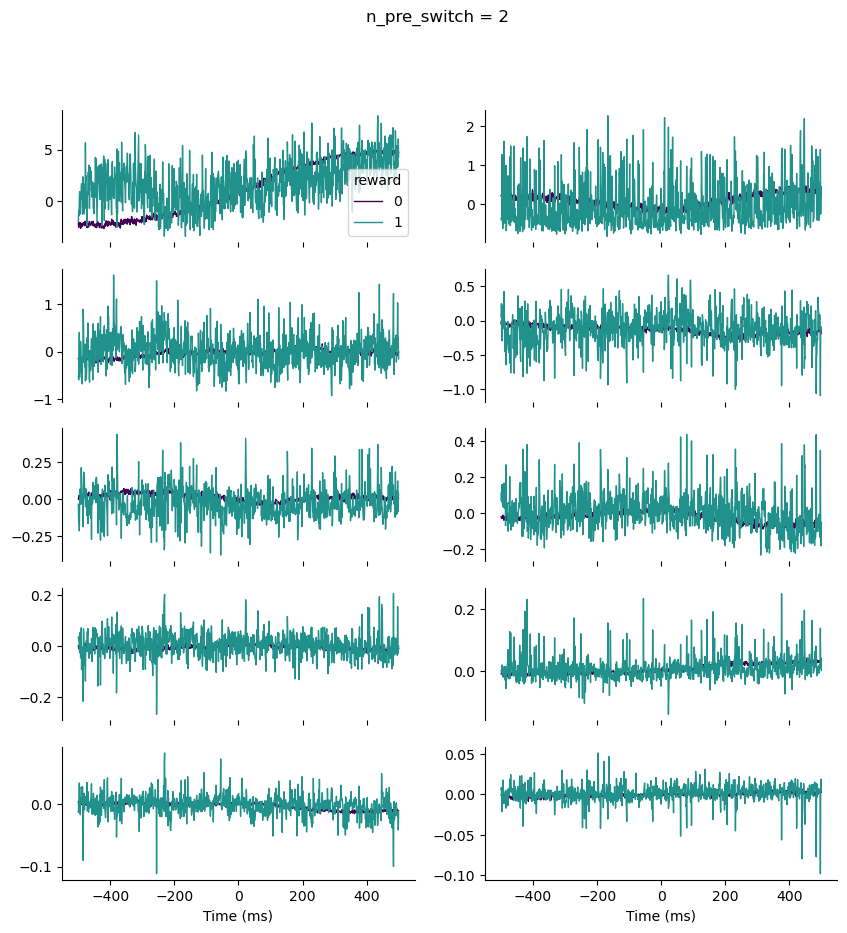

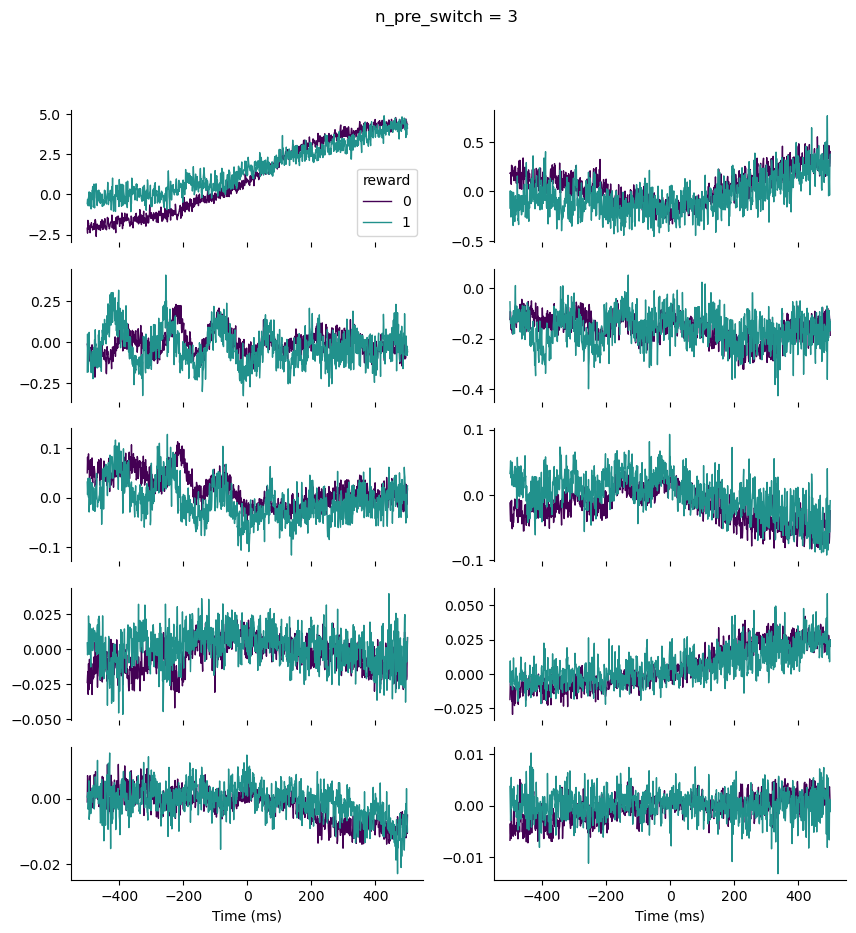

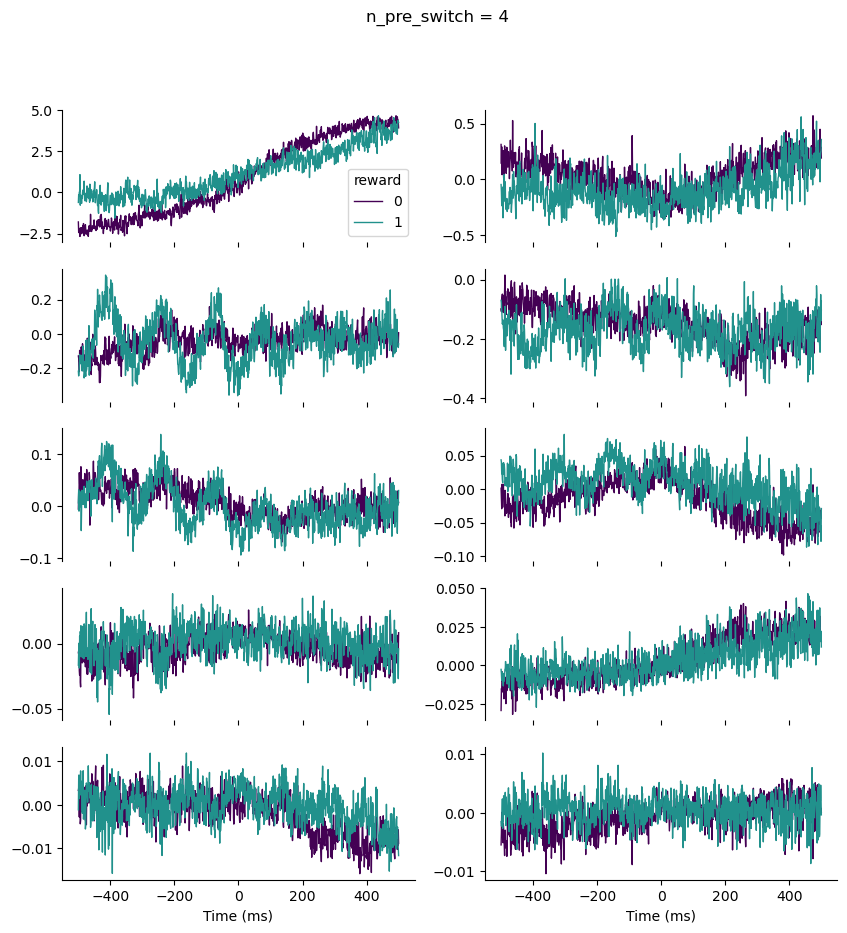

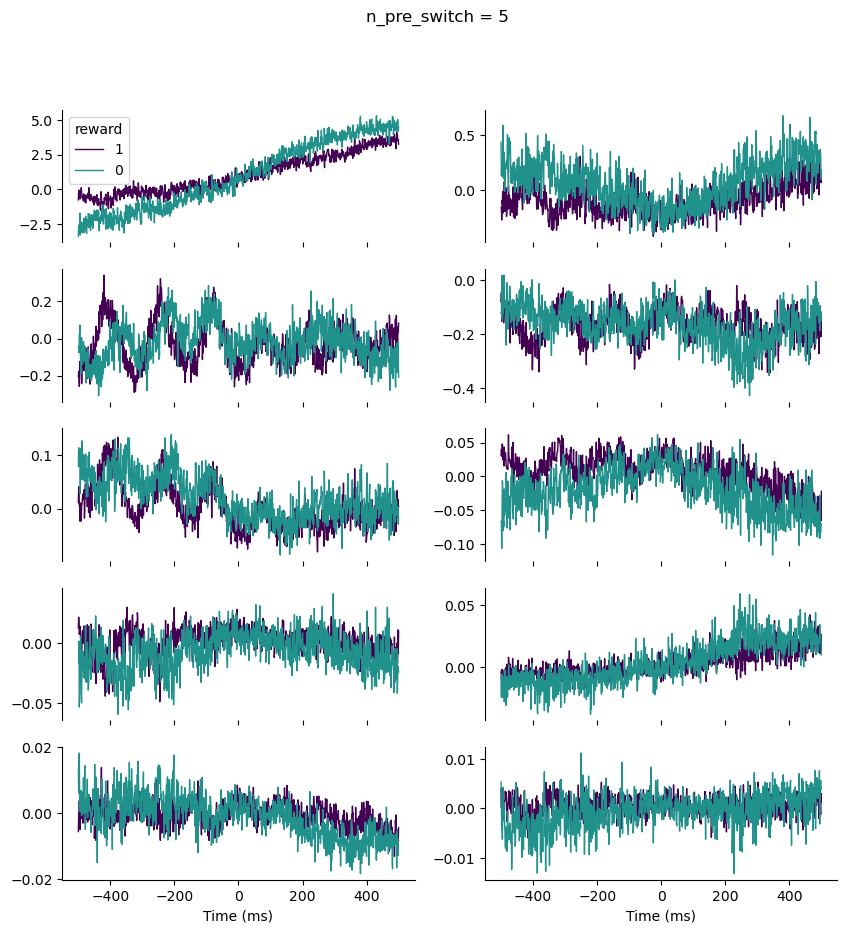

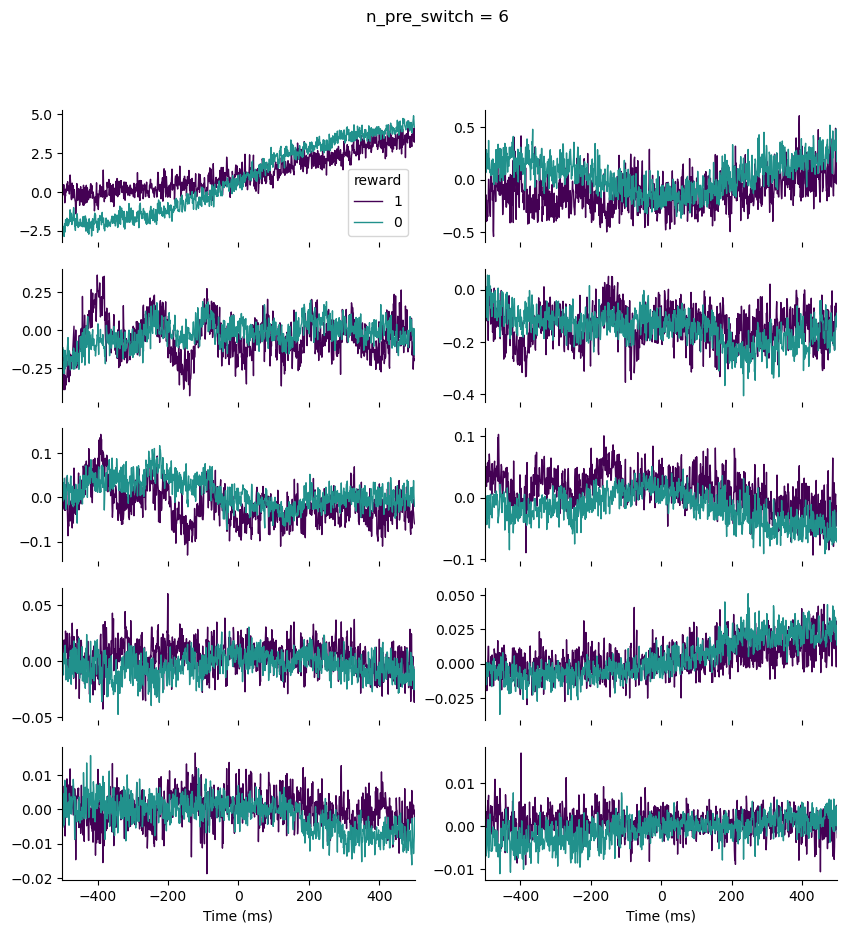

In [ ]:
offset = 0
marks = t_out
window = (-0.5, 0.5)
# group_feature_name = "n_pre_switch"
# feature_bins = None
# feature_bins = [1,3,5,7]#np.arange(5)

# feature_2 = "reward"
# feature_bins_2 = None
# plot_examples = 0

group_feature_name = "reward"
feature_bins = None


feature_2 = "n_pre_switch"
feature_bins_2 = np.arange(7)
plot_examples = 0

#########################################################################


marks_ind = slice(offset, None) if offset >= 0 else slice(None, offset)
feature_ind = slice(None, -offset) if offset > 0 else slice(-offset, None)
marks = marks[marks_ind]

response = analysis.alligned_response(marks, window, pca=True)
t_plot = np.linspace(*window, response.shape[1]) * 1000

# ---------------------------------------------------------------------------'
# Two feature analysis
subset_behav = all_behav.iloc[feature_ind]

unique_vals_2 = (
    subset_behav[feature_2].unique() if feature_bins_2 is None else feature_bins_2
)
for ii, val_2 in enumerate(unique_vals_2):
    ind_2 = all_behav.iloc[feature_ind][feature_2] == val_2

    subset_behav_ii = all_behav.iloc[feature_ind][ind_2]
    response_ii = response[ind_2]

    fig, ax = plt.subplots(
        nrows=context_dim // 2, ncols=2, sharex=True, figsize=(10, 10)
    )
    fig.suptitle(f"{feature_2} = {val_2}")
    ax = np.ravel(ax)

    unique_vals = (
        subset_behav_ii[group_feature_name].unique()
        if feature_bins is None
        else feature_bins
    )
    for i, val in enumerate(unique_vals):
        color = plt.cm.viridis(i / len(unique_vals))
        ind = subset_behav_ii[group_feature_name] == val
        sample_ind = np.random.choice(np.where(ind)[0], plot_examples)
        for i_ax, a in enumerate(ax):
            a.plot(
                t_plot,
                response_ii[ind, ..., i_ax].mean(axis=0),
                label=val,
                color=color,
                zorder=i,
                lw=1,
            )
            # a.plot(
            #     t_plot, response_ii[sample_ind, ..., i].T, alpha=0.1, zorder=-i, color=color,
            # )
            a.spines[["top", "right", "bottom"]].set_visible(False)

    for a in [ax[-1], ax[-2]]:
        a.set_xlabel("Time (ms)")
        a.spines["bottom"].set_visible(True)
    ax[0].legend(title=group_feature_name)
# plt.plot(t_plot, response.mean(axis=0))
plt.xlim(-500, 500)

### Quantile grouped

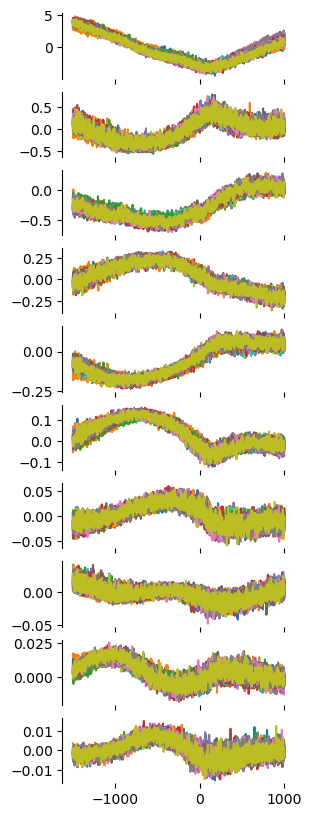

In [ ]:
marks = t_poke[:]
window = (-1.5, 1)
group_feature_name = "stem_stay_p"
percentile_bins = np.linspace(0, 100, 20)


response = analysis.alligned_response(marks, window, pca=True)
t_plot = np.linspace(*window, response.shape[1]) * 1000
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(3, 10))

for i in range(len(percentile_bins) - 1):
    ind = np.where(
        all_behav[group_feature_name].between(
            np.percentile(all_behav[group_feature_name], percentile_bins[i]),
            np.percentile(all_behav[group_feature_name], percentile_bins[i + 1]),
        )
    )[0]

    for i, a in enumerate(ax):
        a.plot(t_plot, response[ind, ..., i].mean(axis=0))
        a.spines[["top", "right", "bottom"]].set_visible(False)
# plt.plot(t_plot, response.mean(axis=0))
# plt.xlim(-200,200)

# Extract Feature Phase

In [477]:
center = np.array(t_out)[all_behav["reward"].values == 1][:]
window = (-0.5, 0)

test_intervals = np.array([(c + window[0], c + window[1]) for c in center])
test_intervals = np.array([t_poke, t_out]).T

t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.fit_context_pca(test_intervals)
analysis.embed_context_pca()
analysis.interpolate_context(t_interp)

In [478]:
from spyglass.common import FirFilterParameters

data = analysis.c_pca_interp[::1]
# data = analysis.c_interp[::1]
t_data = analysis.t_interp[::1]

# data = data[:100000]
# t_data = t_data[:100000]
np.mean(np.diff(t_data))


filter_query = FirFilterParameters() & {
    "filter_sampling_rate": 1000,
    "filter_name": "Theta 5-11 Hz",
}  # .fetch("filter_name")
filter = (filter_query).fetch(as_dict=True)
filter_coeff = filter[0]["filter_coeff"]

f, t_f = FirFilterParameters().filter_data(
    t_data,
    data,
    filter_coeff,
    [[t_data[0], t_data[-1]]],
    np.arange(context_dim),
    1,
)

In [479]:
import pandas as pd
from scipy.signal import hilbert

analytic_signal_df = pd.DataFrame(
    hilbert(f, axis=0),
    index=pd.Index(t_f, name="time"),
    # columns=[f"electrode {e}" for e in electrode_list],
)
phase_df = pd.DataFrame(
    np.angle(analytic_signal_df) + np.pi,
    columns=analytic_signal_df.columns,
    index=analytic_signal_df.index,
)
power_df = pd.DataFrame(
    np.abs(analytic_signal_df) ** 2,
    columns=analytic_signal_df.columns,
    index=analytic_signal_df.index,
)

In [214]:
from src.c3po.analysis.analysis import bootstrap_traces

Text(0.5, 0.98, 'Context theta band power')

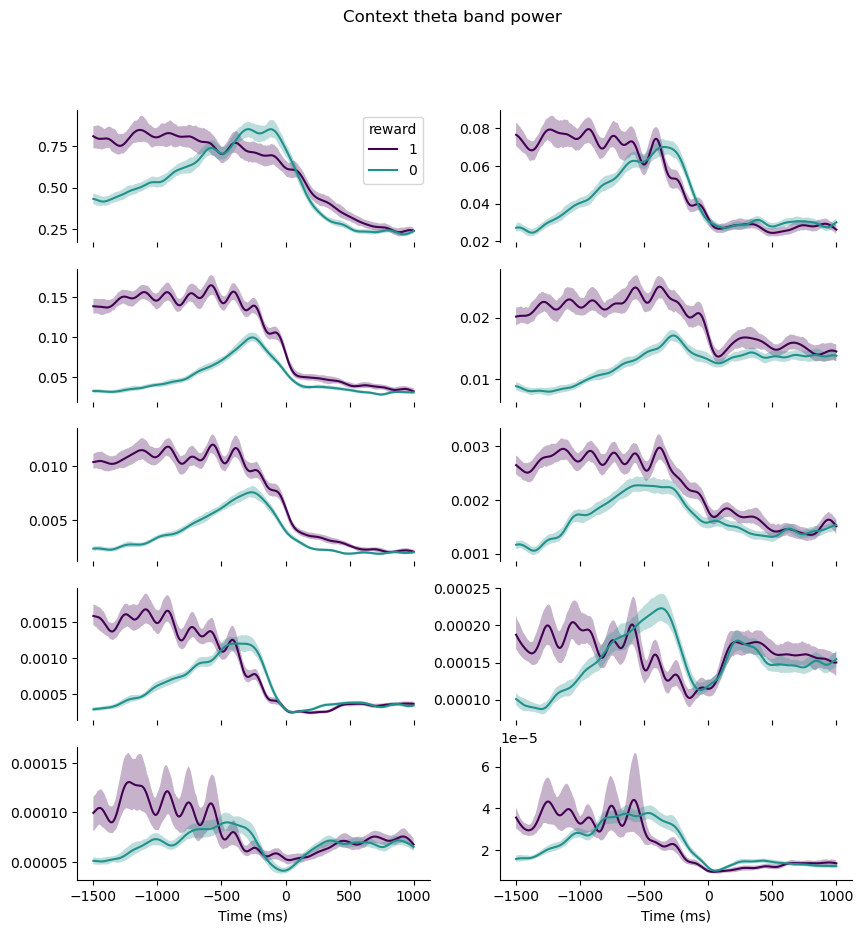

In [480]:
offset = 0
marks = t_out
window = (-1.5, 1)
group_feature_name = "n_pre_switch"
feature_bins = None
feature_bins = np.arange(5)

group_feature_name = "reward"
feature_bins = None

plot_examples = 0
#########################################################################


marks_ind = slice(offset, None) if offset >= 0 else slice(None, offset)
feature_ind = slice(None, -offset) if offset > 0 else slice(-offset, None)
marks = marks[marks_ind]

response = analysis.alligned_response(
    marks,
    window,
    passed_data=(power_df.values, power_df.index),
)
t_plot = np.linspace(*window, response.shape[1]) * 1000


# ---------------------------------------------------------------------------'
# Single feature analysis
fig, ax = plt.subplots(nrows=context_dim // 2, ncols=2, sharex=True, figsize=(10, 10))
ax = np.ravel(ax)
subset_behav = all_behav.iloc[feature_ind]

unique_vals = (
    subset_behav[group_feature_name].unique() if feature_bins is None else feature_bins
)
for i, val in enumerate(unique_vals):
    color = plt.cm.viridis(i / len(unique_vals))
    ind = subset_behav[group_feature_name] == val
    sample_ind = np.random.choice(np.where(ind)[0], plot_examples)
    for i, a in enumerate(ax):
        data_i = response[ind, ..., i]
        yy, rng = bootstrap_traces(data_i, n_boot=100)
        a.fill_between(
            t_plot,
            *rng,
            alpha=0.3,
            facecolor=color,
        )
        a.plot(t_plot, yy, label=val, color=color)

        # a.plot(t_plot, data_i.mean(axis=0), label=val, color=color)
        a.spines[["top", "right", "bottom"]].set_visible(False)

for a in [ax[-1], ax[-2]]:
    a.set_xlabel("Time (ms)")
    a.spines["bottom"].set_visible(True)
ax[0].legend(title=group_feature_name)
fig.suptitle("Context theta band power")

# plt.plot(t_plot, response.mean(axis=0))
# plt.xlim(-500,500)

# Spiking response to theta phase in context

In [426]:
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

key = {"nwb_file_name": "wilbur20210404_.nwb"}
spikes_query = SortedSpikesGroup() & key

spikes_query
spikes_key = spikes_query.fetch1("KEY")
spikes = (spikes_query).fetch_spike_data(spikes_key)

In [631]:
len(t_out), len(center)

(1500, 991)

In [649]:
from spyglass.common import interval_list_contains, interval_list_contains_ind

s = spikes[0]
bins = np.linspace(0, 2 * np.pi, 100)
center = np.array(t_out)[all_behav["reward"].values == 1][:]
window = (-0.5, 0.4)

# center = np.array(t_poke)[all_behav["reward"].values == 1]
# window = (.2,.5)

t_data = phase_df.index
data = phase_df.values
test_intervals = np.array([(c + window[0], c + window[1]) for c in center])
test_intervals = np.array([t_poke, t_out]).T
test_intervals = test_intervals[all_behav["reward"].values == 0]


ind_data = interval_list_contains_ind(test_intervals, t_data)
counts = np.array(
    [np.histogram(data[ind_data, i], bins=bins)[0] for i in range(data.shape[1])]
).T
phase_densities = []
for s_full in spikes:
    s = interval_list_contains(test_intervals, s_full)
    # if len(s) < 100:
    #     continue

    data_s = data[np.digitize(s, t_data), :]
    h = np.array(
        [np.histogram(data_s[:, i_c], bins=bins)[0] for i_c in range(data.shape[1])]
    ).T
    # h = h / h.sum(axis=0)
    h = h / counts
    phase_densities.append(h)
phase_densities = np.array(phase_densities)

In [644]:
all_behav["reward"].values == 1

array([ True,  True, False, ...,  True,  True, False])

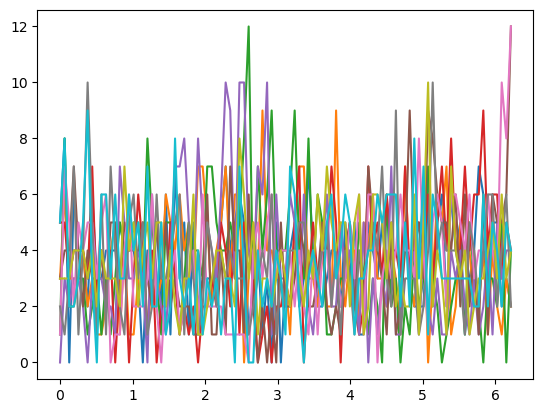

In [650]:
all_poke_intervals[:, 0]
p = interval_list_contains(test_intervals, all_poke_intervals[:, 0])

data_p = data[np.digitize(p, t_data), :]
h = np.array(
    [np.histogram(data_p[:, i_c], bins=bins)[0] for i_c in range(data.shape[1])]
).T
# h = h / h.sum(axis=0)
poke_density = h / counts


plt.plot(bins[:-1], h)

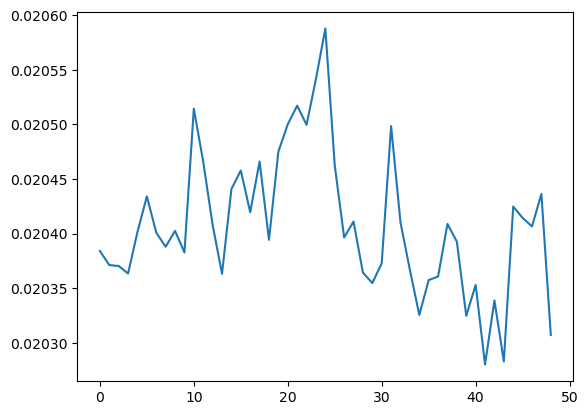

In [510]:
from spyglass.common import interval_list_contains_ind

# ind_data = interval_list_contains_ind(test_intervals, t_data)

counts = np.array(
    [np.histogram(data[ind_data, i], bins=bins)[0] for i in range(data.shape[1])]
).T
h.shape, counts.shape
c_i = counts[:, i]
c_i = c_i / np.sum(c_i)
plt.plot(c_i)

In [345]:
vals.shape

(329, 49)

Text(0, 0.5, 'Cell')

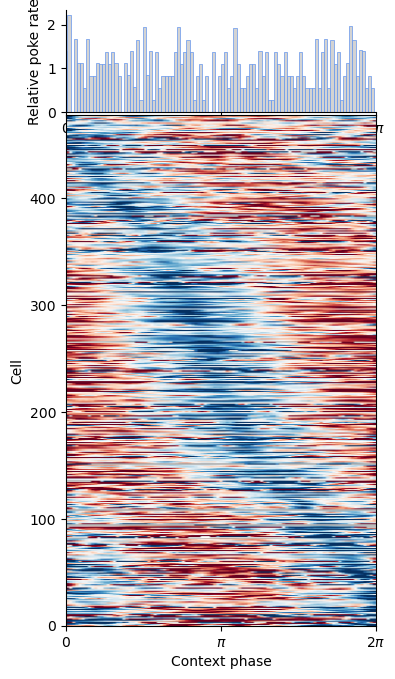

In [651]:
# fig,ax = plt.subplots(nrows=2,sharex=True,height_ratios=[1,10])
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(4, 8))  # Adjust figure size if needed
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 10], hspace=0.01)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

poke_val = poke_density[:, 0]
poke_val = poke_val / np.mean(poke_val)
# poke_val = np.log2(poke_val)
ax0.bar(
    bins[:-1],
    poke_val,
    facecolor="lightgrey",
    edgecolor="cornflowerblue",
    lw=0.5,
    width=np.diff(bins)[0],
)
ax0.set_xticks(
    [],
)
ax0.spines[
    [
        "top",
        "right",
    ]
].set_visible(False)
ax0.set_ylabel("Relative poke rate")

vals = phase_densities[:, :, 0]
vals = vals / np.mean(vals, axis=1)[:, None]
# vals = vals-(1/vals.shape[1])
# vals = vals / (1 / vals.shape[1])
# vals = np.concatenate([vals, vals], axis=1)
vals = np.array(
    [
        smooth(
            vals[i, :],
            n=10,
            sigma=3,
        )
        for i in range(vals.shape[0])
    ]
)

vals = np.log2(vals)

# ind_sort = np.argsort(np.argmax(vals, axis=1))
#

c_scale = 0.3
ax1.imshow(
    vals[ind_sort],
    aspect="auto",
    cmap="RdBu",
    clim=(-c_scale, c_scale),
    extent=[bins[0], bins[-1], 0, vals.shape[0]],
)
ax1.set_xticks([0, np.pi, 2 * np.pi], ["0", "$\pi$", "$2\pi$"])

ax1.set_xlabel("Context phase")
ax1.set_ylabel("Cell")
# plt.colorbar()
# plt.title("log2 firing rate/mean firing rate")

In [514]:
vals.shape

(467, 49)

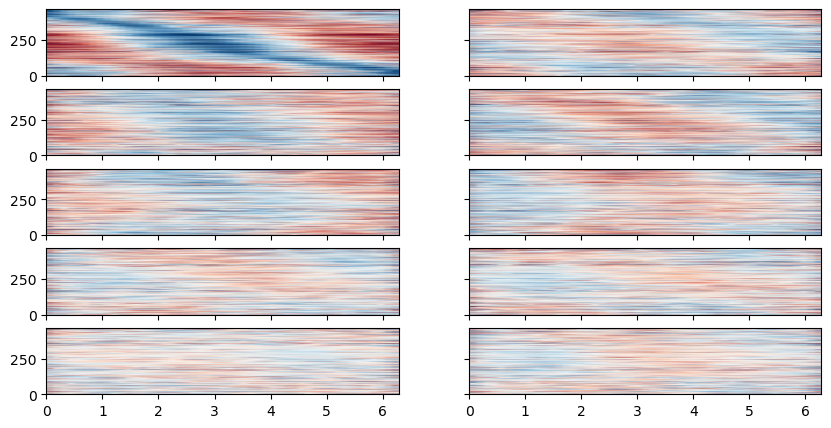

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10, 5), sharex=True, sharey=True)

for i, a in enumerate(ax.flatten()):
    vals = phase_densities[:, :, i]
    vals = vals / np.mean(vals, axis=1)[:, None]
    # vals = vals-(1/vals.shape[1])
    # vals = vals / (1 / vals.shape[1])
    vals = np.array([smooth(vals[i, :], n=10, sigma=2) for i in range(vals.shape[0])])

    vals = np.log2(vals)

    # ind_sort = np.argsort(np.argmax(vals, axis=1))

    c_scale = 0.2
    a.imshow(
        vals[ind_sort],
        aspect="auto",
        cmap="RdBu",
        clim=(-c_scale, c_scale),
        extent=[bins[0], bins[-1], 0, vals.shape[0]],
    )

# plt.xlabel("Context phase")
# plt.ylabel("Cell")
# plt.colorbar()
# plt.title("log2 firing rate/mean firing rate")

In [271]:
h.sum(axis=0).shape

(10,)

# Figurl generation

In [ ]:
trial_intervals = np.array([t_out[:n_trials], t_poke[1 : n_trials + 1]]).T
trial_intervals = trial_intervals
t_0 = trial_intervals[0][0] - 1
plot_interval = np.array([[t_0, t_0 + 1000]])

from spyglass.common import interval_list_contains_ind

ind_mark = interval_list_contains_ind(plot_interval, analysis.t)

array([2834124, 2834125, 2834126, ..., 4798658, 4798659, 4798660])

In [588]:
from spyglass.lfp.v1 import LFPV1

query = LFPV1() & {
    "nwb_file_name": "wilbur20210404_.nwb",
    "target_interval_list_name": "02_r1 noPrePostTrialTimes",
}

lfp_df = query.fetch1_dataframe()
t_lfp = lfp_df.index.values
# t_lfp = t_lfp - first_mark_time
ind_lfp = interval_list_contains_ind(plot_interval, t_lfp)

In [590]:
from spyglass.position.v1 import TrodesPosV1
from spyglass.common.common_position import IntervalPositionInfo

pos_key = {
    "nwb_file_name": "wilbur20210404_.nwb",
    "interval_list_name": "pos 1 valid times",
    "position_info_param_name": "default",
}
# TrodesPosV1 & key
pos_query = IntervalPositionInfo & pos_key
pos_df = pos_query.fetch1_dataframe()
t_pos = pos_df.index.values
# t_pos = t_pos - first_mark_time
ind_pos = interval_list_contains_ind(plot_interval, t_pos)
speed = pos_df.head_speed.values

In [592]:
from pynwb import NWBHDF5IO
from spyglass.utils.nwb_helper_fn import get_nwb_file
from spyglass.utils.dj_helper_fn import _get_nwb_object
from spyglass.common import DIOEvents, Nwbfile
import numpy as np

file_path = Nwbfile().get_abs_path("wilbur20210404_.nwb")
nwb = get_nwb_file(file_path)
dio_query = (
    DIOEvents()
    & {"nwb_file_name": "wilbur20210404_.nwb"}
    & "dio_event_name LIKE 'pump%'"
)

pump_obj_ids = dio_query.fetch("dio_object_id")
all_pump_intervals = []
for obj_id in pump_obj_ids:
    obj = _get_nwb_object(nwb.objects, obj_id)
    state = obj.data[:]
    state_time = obj.timestamps[:]
    ind_on = np.where(state == 1)[0]
    pump_intervals = [
        [st, en] for st, en in zip(state_time[ind_on], state_time[ind_on + 1])
    ]
    all_pump_intervals.extend(pump_intervals)
all_pump_intervals = np.array(all_pump_intervals)
ind = np.argsort(all_pump_intervals[:, 0])
all_pump_intervals = all_pump_intervals[ind]
all_pump_intervals = interval_list_intersect(all_pump_intervals, plot_interval)

dio_query = (
    DIOEvents()
    & {"nwb_file_name": "wilbur20210404_.nwb"}
    & "dio_event_name LIKE 'poke%'"
)
poke_obj_ids = dio_query.fetch("dio_object_id")
all_poke_intervals = []
for obj_id in poke_obj_ids:
    obj = _get_nwb_object(nwb.objects, obj_id)
    state = obj.data[:]
    state_time = obj.timestamps[:]
    ind_on = np.where(state == 1)[0]
    poke_intervals = [
        [st, en] for st, en in zip(state_time[ind_on], state_time[ind_on + 1])
    ]
    all_poke_intervals.extend(poke_intervals)
all_poke_intervals = np.array(all_poke_intervals)
ind = np.argsort(all_poke_intervals[:, 0])
all_poke_intervals = all_poke_intervals[ind]
all_poke_intervals = interval_list_intersect(all_poke_intervals, plot_interval)

In [606]:
from spyglass.utils.spikesorting import firing_rate_from_spike_indicator

time_mua = np.arange(np.min(plot_interval), np.max(plot_interval), 0.005)
min_time, max_time = time_mua[[0, -1]]
spike_times = list([*times_list])
spike_indicator = np.zeros((len(time_mua), len(spike_times)))

for ind, times in enumerate(spike_times):
    times = times[np.logical_and(times >= min_time, times <= max_time)]
    spike_indicator[:, ind] = np.bincount(
        np.digitize(times, time_mua[1:-1]),
        minlength=time_mua.shape[0],
    )

if spike_indicator.ndim == 1:
    spike_indicator = spike_indicator[:, np.newaxis]

mua_plot = firing_rate_from_spike_indicator(spike_indicator, time_mua, multiunit=True)

In [652]:
import sortingview.views as vv

color_list = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

# CONTEXT
# subsample = 10
# context_graph = vv.TimeseriesGraph()
# c_fig = pca.transform(c[ind_mark])
# c_fig = smooth(c_fig, sigma=int(10), hamming=True)
# c_fig = c_fig[::subsample]
# for i in np.arange(
#     8,
# ):
#     context_graph.add_line_series(
#         name=f"context pc: {i}",
#         t=mark_times[ind_mark[::subsample]] / 1000,
#         y=c_fig[:, i].astype(np.float32),
#         width=2,
#         color=color_list[i],
#     )

subsample = 10
context_graph = vv.TimeseriesGraph()
c_fig = analysis.c_pca
c_fig = smooth(c_fig, sigma=int(10), hamming=True)
c_fig = c_fig[::subsample]
t_fig = analysis.t

for i in np.arange(
    3,
):
    context_graph.add_line_series(
        name=f"context pc: {i}",
        t=t_fig[ind_mark[::subsample]],
        y=c_fig[:, i].astype(np.float32),
        width=2,
        color=color_list[i],
    )


context_graph2 = vv.TimeseriesGraph()
for i in np.arange(3, 7):
    context_graph2.add_line_series(
        name=f"context pc: {i}",
        t=t_fig[ind_mark[::subsample]],
        y=c_fig[:, i].astype(np.float32),
        width=2,
        color=color_list[i],
    )


# LFP
lfp_graph = vv.TimeseriesGraph()
lfp_graph.add_line_series(
    name="lfp",
    t=t_lfp[ind_lfp],
    y=lfp_df.iloc[ind_lfp][0].values,
    width=2,
    color="black",
)

# Speed
speed_graph = vv.TimeseriesGraph()
# speed_graph.add_interval_series(
#     name="stay trials",
#     t_start=stay_intervals[:, 0],
#     t_end=stay_intervals[:, 1],
#     color="grey",
# )
# speed_graph.add_interval_series(
#     name="switch trials",
#     t_start=switch_intervals[:, 0],
#     t_end=switch_intervals[:, 1],
#     color="firebrick",
# )

speed_graph.add_interval_series(
    name="poke_times",
    t_start=all_poke_intervals[:, 0],
    t_end=all_poke_intervals[:, 1],
    color="pink",
)

speed_graph.add_interval_series(
    name="reward_pump",
    t_start=all_pump_intervals[:, 0],
    t_end=all_pump_intervals[:, 1],
    color="cornflowerblue",
)

speed_graph.add_line_series(
    name="speed",
    t=t_pos[ind_pos].astype(np.float32),
    y=speed[ind_pos].astype(np.float32),
    width=2,
    color="teal",
)

# MUA
mua_graph = vv.TimeseriesGraph()
mua_graph.add_line_series(
    name="mua",
    t=time_mua.astype(np.float32),
    y=mua_plot.astype(np.float32),
    width=2,
    color="k",
)

# ASSEMBLE
context_panels = [
    vv.LayoutItem(speed_graph, stretch=1),
    vv.LayoutItem(lfp_graph, stretch=1),
    vv.LayoutItem(mua_graph, stretch=1),
    vv.LayoutItem(context_graph, stretch=3),
    vv.LayoutItem(context_graph2, stretch=3),
]

view = vv.Box(
    direction="horizontal",
    show_titles=True,
    height=8,
    items=[
        vv.LayoutItem(
            vv.Box(
                direction="vertical",
                show_titles=True,
                items=context_panels,
            )
        ),
    ],
)
view.url(label="test url")


Kachery let's scientist store data files in the cloud for the purpose of using
cloud-based visualization tools and collaborating with others. This is a free
service when used for scientific research purposes. In order to use it, you must
register using your GitHub account, provide your email, and briefly describe the
purpose of the research. To register, visit https://kachery.vercel.app. Then set
the KACHERY_API_KEY environment variable to your API key.

Alternatively, you can use the "scratch" zone which is subject to regular deletion
of files by setting the KACHERY_ZONE environment variable to "scratch".

For more information, visit https://github.com/magland/kachery.



Exception: KACHERY_API_KEY environment variable is not set

In [ ]:
import sortingview

sortingview.__version__

import kachery_cloud as kcl

kcl.__version__

AttributeError: module 'kachery_cloud' has no attribute '__version__'